In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten,LeakyReLU,BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, Concatenate
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm

In [4]:
# Set some parameters
im_width = 256
im_height = 256
ids1 = next(os.walk("/kaggle/input/brain-tumor-segmentation/images/"))[2]
X = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(ids1), total=len(ids1)):
    # Load images
    img = load_img("/kaggle/input/brain-tumor-segmentation/images/" + id_, color_mode = 'grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode='constant', preserve_range=True)
    # Load masks
    mask = img_to_array(load_img("/kaggle/input/brain-tumor-segmentation/masks/" + id_, color_mode='grayscale'))
    mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)
    # Save images
    X[n] = x_img / 255.0
    y[n] = mask / 255.0

100%|██████████| 3064/3064 [01:45<00:00, 28.93it/s]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,shuffle=True)

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    #print(s4.shape , p4.shape)
    s5, p5 = encoder_block(p4, 1024)
    print(s5.shape , p5.shape)
    
    b1 = conv_block(p5, 2048)


    d1 = decoder_block(b1, s5, 1024)
    d2 = decoder_block(d1, s4, 512)
    d3 = decoder_block(d2, s3, 256)
    d4 = decoder_block(d3, s2, 128)
    d5 = decoder_block(d4, s1, 64)
    #----------------------------------#
    print("\n")
    print(b1.shape , s5.shape)
    print(d1.shape , s4.shape)
    print(d2.shape , s3.shape)
    print(d3.shape , s2.shape)
    print(d4.shape , s1.shape)
    print("\n")
    print(d5.shape,"\n")
    #----------------------------------#

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)
    print(outputs.shape)
    model = Model(inputs, outputs, name="U-NET")
    return model

model = unet((256,256,1))
model.summary()





(None, 8, 8, 2048) (None, 16, 16, 1024)

(None, 16, 16, 1024) (None, 32, 32, 512)

(None, 32, 32, 512) (None, 64, 64, 256)

(None, 64, 64, 256) (None, 128, 128, 128)

(None, 128, 128, 128) (None, 256, 256, 64)





(None, 256, 256, 64) 



(None, 256, 256, 1)

Model: "U-NET"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            

                                                                                                  

 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             

                                                                                                  

 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              

 Normalization)   

In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=15)

model.save_weights('/kaggle/working/BrainTumor.h5')
model.load_weights('/kaggle/working/BrainTumor.h5')


Epoch 1/15



I0000 00:00:1712007332.998434      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


613/613 [==============================] - 151s 205ms/step - loss: 0.0890 - accuracy: 0.9763

Epoch 2/15

613/613 [==============================] - 120s 196ms/step - loss: 0.0471 - accuracy: 0.9822

Epoch 3/15

613/613 [==============================] - 120s 196ms/step - loss: 0.0400 - accuracy: 0.9835

Epoch 4/15

613/613 [==============================] - 120s 196ms/step - loss: 0.0348 - accuracy: 0.9844

Epoch 5/15

613/613 [==============================] - 120s 196ms/step - loss: 0.0312 - accuracy: 0.9856

Epoch 6/15

613/613 [==============================] - 120s 196ms/step - loss: 0.0283 - accuracy: 0.9865

Epoch 7/15

613/613 [==============================] - 120s 196ms/step - loss: 0.0257 - accuracy: 0.9872

Epoch 8/15

613/613 [==============================] - 120s 196ms/step - loss: 0.0233 - accuracy: 0.9878

Epoch 9/15

613/613 [==============================] - 120s 196ms/step - loss: 0.0211 - accuracy: 0.9886

Epoch 10/15

613/613 [==============================] - 12

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Predict masks on test data
y_pred = model.predict(X_test)

# Convert predicted masks to binary values
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test = (y_test > 0.5).astype(np.uint8)



20/20 [==============================] - 30s 484ms/step - loss: 0.0235 - accuracy: 0.9884

Test Accuracy: 0.9884337782859802

20/20 [==============================] - 6s 285ms/step


In [ ]:
X_test.shape

(613, 256, 256, 1)

In [ ]:
import random
rand_num = random.randint(0,613)
print(rand_num)

483


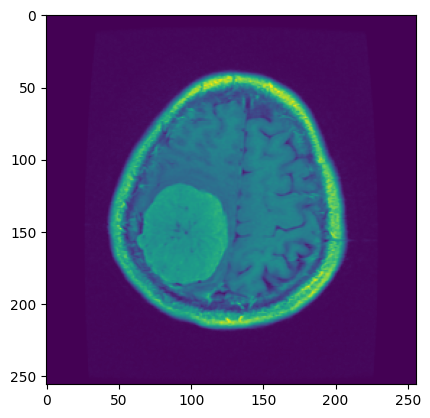

In [ ]:
img_demo = X_test[rand_num]
plt.imshow(img_demo)

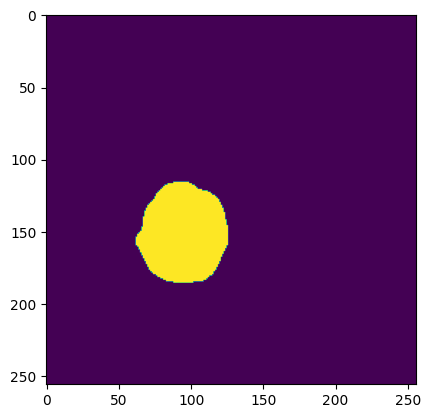

In [ ]:
seg_demo = y_test[rand_num]
plt.imshow(seg_demo)

In [ ]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2.0 * intersection) / (union + intersection)
    return dice
dice_scores = []
for i in range(len(X_test)):
    dice = dice_coefficient(y_test[i], y_pred_binary[i])
    dice_scores.append(dice)
average_dice = np.mean(dice_scores)
print("Average Dice Score:", average_dice)


Average Dice Score: 0.4584740855838993
